In [1]:
from ipyleaflet import (Map, GeoData, basemaps, WidgetControl, GeoJSON,
                        LayersControl, Icon, Marker,basemap_to_tiles, Choropleth,
                        MarkerCluster, Heatmap,SearchControl, 
                        FullScreenControl)

from ipywidgets import Text, HTML
from branca.colormap import linear
import geopandas as gpd
import pandas as pd
import json
from dotenv import load_dotenv
load_dotenv()
import requests
from requests.auth import HTTPBasicAuth
import os
from shapely.geometry import Point
from geopandas.tools import sjoin
from shapely.geometry import Point, LineString, Polygon
import contextily as cx
import matplotlib.pyplot as plt
import numpy as np
import warnings
import osmnx as ox
import networkx as nx

In [2]:
url = os.getenv('COUCHDB_URL')+"/bike_locations/_design/datetime_doc/_view/datetime-index?limit=50000&include_docs=true&descending=true"

payload={}
response = requests.get(url, data=payload, auth=HTTPBasicAuth(os.getenv('COUCHDB_USER'), os.getenv('COUCHDB_PASSWORD')))

data = [row['doc'] for row in response.json()['rows']]
for d in data:
    d.pop('_id', None)
    d.pop('_rev', None)
bike_locations_df = pd.DataFrame(data)
bike_locations=gpd.GeoDataFrame(bike_locations_df, crs=4326, geometry=gpd.points_from_xy(bike_locations_df.lon, bike_locations_df.lat))
bike_locations.drop(columns=['lat', 'lon'],inplace=True)
print(len(bike_locations.index))
bike_locations.head()

50000


,id,datetime,geometry
0,YVO:Vehicle:fda2ce0f-eda9-4138-b953-b38e65db945a,2021-12-29T18:00:12.477Z,POINT (10.75003 59.91203)
1,YBO:Vehicle:f343c72e-7c48-49ac-b9fb-3d27eb1ab5d5,2021-12-29T18:00:12.475Z,POINT (10.76081 59.91028)
2,YTI:Vehicle:2841e6a304a3e2b88dd8eb221ce1a0e196...,2021-12-29T18:00:12.473Z,POINT (10.49328 59.89643)
3,YTI:Vehicle:ac7856bb15e131826ec525dc790c250132...,2021-12-29T18:00:12.471Z,POINT (10.75065 59.91708)
4,YBO:Vehicle:6a6d7e41-df2f-4f21-afd3-46376a5ef75f,2021-12-29T18:00:12.469Z,POINT (10.71464 59.91316)


In [3]:
#Removing points only mentioned once
bike_locations=bike_locations[bike_locations.groupby('id').id.transform('count') > 1]
print('Number of bikes with mutible points:',bike_locations.shape[0])

Number of bikes with mutible points: 49993


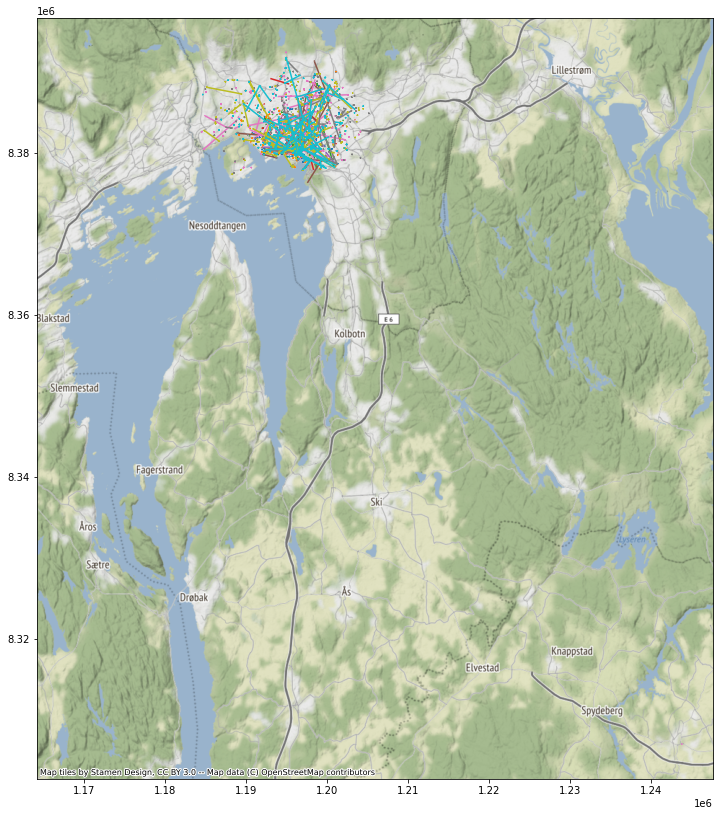

In [4]:
#inspired by: https://pygis.io/docs/e_new_vectors.html 
lines = bike_locations.to_crs(epsg=3857).groupby(['id'])['geometry'].apply(lambda x:  LineString(x.tolist()))#LineString(x.tolist())
lines = gpd.GeoDataFrame(lines, geometry='geometry', crs="EPSG:3857") 
lines.reset_index(inplace=True)
f, ax1 = plt.subplots(1, figsize=(14, 14))
ax1=lines.plot(column='id',ax=ax1)
cx.add_basemap(ax1)

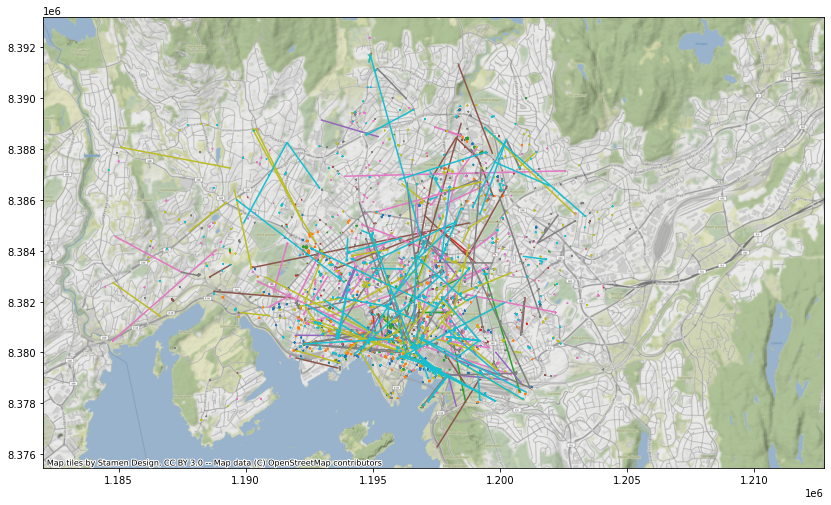

In [5]:
oslo=gpd.read_file('oslo_geojson/oslo.geojson',crs=4326)
bike_locations_in_oslo = sjoin(bike_locations,oslo, how='left')
bike_locations_in_oslo.dropna(subset = ["index_right"], inplace=True)
lines_in_oslo = bike_locations_in_oslo.to_crs(epsg=3857).groupby(['id'])['geometry'].apply(lambda x:  LineString(x.tolist()))#LineString(x.tolist())
lines_in_oslo = gpd.GeoDataFrame(lines_in_oslo, geometry='geometry', crs="EPSG:3857") 
lines_in_oslo.reset_index(inplace=True)
f, ax1 = plt.subplots(1, figsize=(14, 14))
ax1=lines_in_oslo.plot(column='id',ax=ax1)
cx.add_basemap(ax1)

In [6]:
bike_locations_sorted=bike_locations_in_oslo.sort_values(by=['id','datetime'])
bike_locations_sorted=bike_locations_sorted.to_crs(epsg=5234)
bike_locations_sorted.head()

,id,datetime,geometry,index_right
47990,YBO:Vehicle:01593162-0b8c-4e08-baf0-d75efbe49923,2021-12-29T14:15:06.917Z,POINT (-3067552.580 8177943.907),0.0
44966,YBO:Vehicle:01593162-0b8c-4e08-baf0-d75efbe49923,2021-12-29T14:30:07.231Z,POINT (-3067556.739 8177940.129),0.0
41941,YBO:Vehicle:01593162-0b8c-4e08-baf0-d75efbe49923,2021-12-29T14:45:06.759Z,POINT (-3067560.407 8177937.670),0.0
38923,YBO:Vehicle:01593162-0b8c-4e08-baf0-d75efbe49923,2021-12-29T15:00:06.794Z,POINT (-3067557.835 8177936.522),0.0
35906,YBO:Vehicle:01593162-0b8c-4e08-baf0-d75efbe49923,2021-12-29T15:15:07.031Z,POINT (-3067555.755 8177936.544),0.0


In [7]:
new_table = [] 
for name, group in bike_locations_sorted.groupby('id',sort=True):
    group.to_crs(epsg=5234,inplace=True)
    group["meters_to_next_point"]=group.distance(group.shift(-1))
    group.to_crs(epsg=3857,inplace=True)
    group['from']=group['geometry']
    group['to']=group.shift(-1)['geometry']
    group['datetime_from']=group['datetime']
    group['datetime_to']=group.shift(-1)['datetime']
    d.pop('datetime', None)
    group.drop(group.tail(1).index,inplace=True)
    group1 = group.copy()
    if len(new_table)==0:
        new_table = [group1]
    else:
        new_table.append(group1)

        
        
movements = pd.concat(new_table).reset_index(drop=True)
movements['geometry'] = movements.apply(lambda row: LineString([row['from'], row['to']]), axis=1) #Create a linestring column
movements.head()



/Users/hakon/opt/anaconda3/envs/location-data-cleaner/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,id,datetime,geometry,index_right,meters_to_next_point,from,to,datetime_from,datetime_to
0,YBO:Vehicle:01593162-0b8c-4e08-baf0-d75efbe49923,2021-12-29T14:15:06.917Z,"LINESTRING (1198278.392 8385146.963, 1198281.6...",0.0,5.618773,POINT (1198278.392 8385146.963),POINT (1198281.683 8385137.639),2021-12-29T14:15:06.917Z,2021-12-29T14:30:07.231Z
1,YBO:Vehicle:01593162-0b8c-4e08-baf0-d75efbe49923,2021-12-29T14:30:07.231Z,"LINESTRING (1198281.683 8385137.639, 1198283.1...",0.0,4.416011,POINT (1198281.683 8385137.639),POINT (1198283.169 8385130.011),2021-12-29T14:30:07.231Z,2021-12-29T14:45:06.759Z
2,YBO:Vehicle:01593162-0b8c-4e08-baf0-d75efbe49923,2021-12-29T14:45:06.759Z,"LINESTRING (1198283.169 8385130.011, 1198286.7...",0.0,2.816153,POINT (1198283.169 8385130.011),POINT (1198286.778 8385133.401),2021-12-29T14:45:06.759Z,2021-12-29T15:00:06.794Z
3,YBO:Vehicle:01593162-0b8c-4e08-baf0-d75efbe49923,2021-12-29T15:00:06.794Z,"LINESTRING (1198286.778 8385133.401, 1198288.1...",0.0,2.080307,POINT (1198286.778 8385133.401),POINT (1198288.159 8385136.792),2021-12-29T15:00:06.794Z,2021-12-29T15:15:07.031Z
4,YBO:Vehicle:01593162-0b8c-4e08-baf0-d75efbe49923,2021-12-29T15:15:07.031Z,"LINESTRING (1198288.159 8385136.792, 1198281.4...",0.0,9.028513,POINT (1198288.159 8385136.792),POINT (1198281.470 8385151.201),2021-12-29T15:15:07.031Z,2021-12-29T15:30:07.004Z


array([[<AxesSubplot:title={'center':'meters_to_next_point'}>]],
      dtype=object)

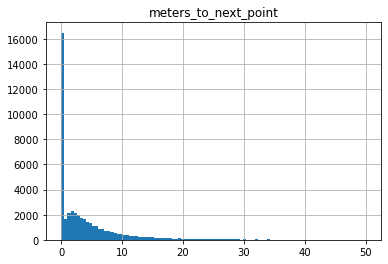

In [8]:
#Looking at distanses shorter than 50m
movements.hist(column='meters_to_next_point',bins=list(np.linspace(0, 50, num=100)))

array([[<AxesSubplot:title={'center':'meters_to_next_point'}>]],
      dtype=object)

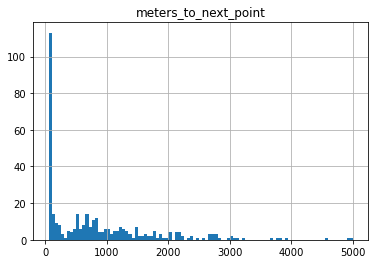

In [9]:
#Lookign at distanses over 50m
movements.hist(column='meters_to_next_point',bins=list(np.linspace(50, 5000, num=100)))

In [10]:
#Removing short movements.
trips=movements[movements['meters_to_next_point']>100].copy()
trips.to_crs(4326,inplace=True)
print('Removed', len(movements)-len(trips),'of',len(movements), 'movements.','Have',len(trips), 'trips left.')

Removed 45474 of 45722 movements. Have 248 trips left.


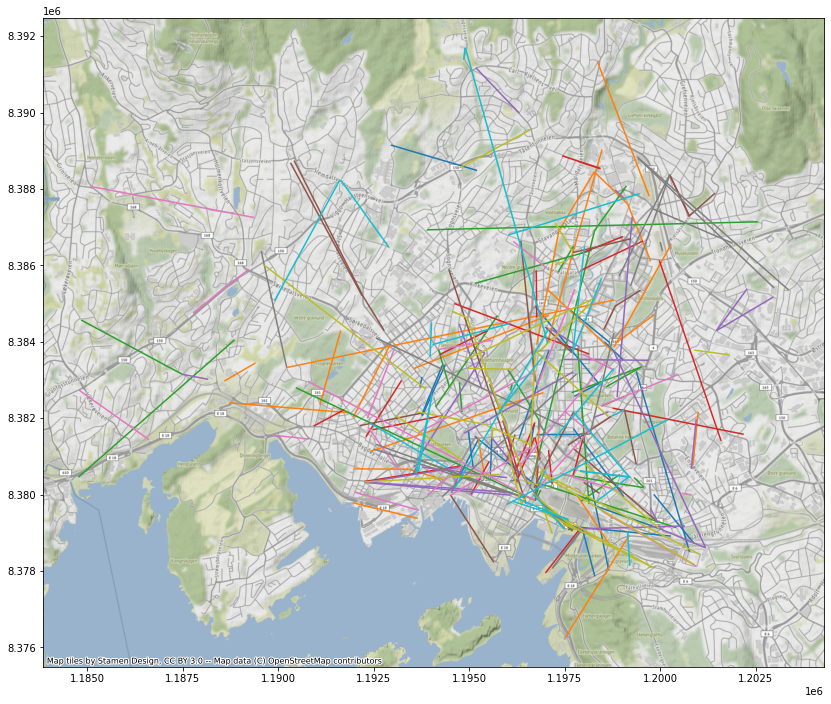

In [11]:
# store as a GeodataFrame and add 'ID' as a column (currently stored as the 'index')
f, ax5 = plt.subplots(1, figsize=(14, 14))
ax5=trips.to_crs(3857).plot(column='id',ax=ax5)
cx.add_basemap(ax5)

In [12]:
trips.to_crs(epsg=4326).head()

,id,datetime,geometry,index_right,meters_to_next_point,from,to,datetime_from,datetime_to
10101,YLI:Vehicle:2NZZQ76OWKXEN,2021-12-29T17:45:06.115Z,"LINESTRING (10.75075 59.91831, 10.76176 59.91834)",0.0,697.728259,POINT (1196767.946 8381572.068),POINT (1197993.129 8381578.508),2021-12-29T17:45:06.115Z,2021-12-29T18:00:06.483Z
11296,YLI:Vehicle:6QWZUIAARTKFK,2021-12-29T17:30:11.873Z,"LINESTRING (10.75957 59.92281, 10.76543 59.92436)",0.0,419.525060,POINT (1197750.230 8382572.432),POINT (1198402.339 8382916.061),2021-12-29T17:30:11.873Z,2021-12-29T17:45:11.810Z
12136,YLI:Vehicle:CMLFQXIEDOTD5,2021-12-29T15:00:06.944Z,"LINESTRING (10.74651 59.91769, 10.75362 59.92824)",0.0,1406.224850,POINT (1196295.618 8381434.595),POINT (1197087.211 8383777.981),2021-12-29T15:00:06.944Z,2021-12-29T15:15:07.183Z
12717,YLI:Vehicle:FLKY6Y3VXBO27,2021-12-29T16:00:10.605Z,"LINESTRING (10.76769 59.90232, 10.76348 59.91260)",0.0,1325.824542,POINT (1198653.921 8378022.136),POINT (1198184.598 8380305.371),2021-12-29T16:00:10.605Z,2021-12-29T16:15:10.541Z
13067,YLI:Vehicle:GOYSW2NYT6MOG,2021-12-29T17:00:09.523Z,"LINESTRING (10.73983 59.91342, 10.74023 59.91809)",0.0,590.842322,POINT (1195552.672 8380485.902),POINT (1195596.754 8381524.096),2021-12-29T17:00:09.523Z,2021-12-29T17:30:09.411Z


2021-12-29 19:16:27 Configured OSMnx 1.1.2
2021-12-29 19:16:27 HTTP response caching is on
2021-12-29 19:16:27 Projected GeoDataFrame to +proj=utm +zone=32 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2021-12-29 19:16:27 Projected GeoDataFrame to epsg:4326
2021-12-29 19:16:27 Projected GeoDataFrame to +proj=utm +zone=32 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2021-12-29 19:16:27 Projected GeoDataFrame to epsg:4326
2021-12-29 19:16:27 Requesting data within polygon from API in 1 request(s)
2021-12-29 19:16:27 Retrieved response from cache file "cache/f77c6daf35414a5d75f111fbd52b45ba7b45df7f.json"
2021-12-29 19:16:27 Got all network data within polygon from API in 1 request(s)
2021-12-29 19:16:27 Creating graph from downloaded OSM data...
2021-12-29 19:16:32 Created graph with 427681 nodes and 856925 edges
2021-12-29 19:16:35 Added length attributes to graph edges
2021-12-29 19:16:35 Identifying all nodes that lie outside the polygon...
2021-12-29 19:16:46 Created 

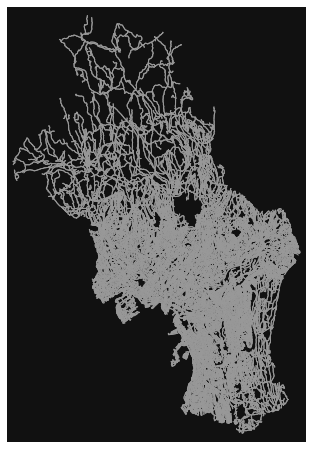

2021-12-29 19:17:58 Finished plotting the graph


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [13]:
ox.config(use_cache=True, log_console=True)
road_graph=ox.graph_from_polygon(oslo['geometry'][0],network_type='bike')
ox.plot_graph(road_graph, node_size=0)

In [14]:
road_graph = ox.add_edge_speeds(road_graph) #Impute
road_graph = ox.add_edge_travel_times(road_graph) #Travel time


2021-12-29 19:18:01 Created edges GeoDataFrame from graph
2021-12-29 19:18:06 Created edges GeoDataFrame from graph


In [15]:
ox.config(use_cache=True, log_console=False)
routes=[]
for trip_coords in trips['geometry']:
    start_node = ox.distance.nearest_nodes(road_graph, trip_coords.coords[0][0], trip_coords.coords[0][1])
    end_node = ox.distance.nearest_nodes(road_graph, trip_coords.coords[1][0], trip_coords.coords[1][1])
    # Calculate the shortest path
    routes.append(nx.shortest_path(road_graph, start_node, end_node, weight='travel_time'))
ox.config(use_cache=True, log_console=True)

2021-12-29 19:19:41 Configured OSMnx 1.1.2
2021-12-29 19:19:41 HTTP response caching is on


2021-12-29 19:19:41 Created bbox 5000 m from (59.914079, 10.750869): 59.959045016774645,59.86911298322536,10.840568150735297,10.661169849264702
2021-12-29 19:19:41 Begin plotting the graph...
2021-12-29 19:19:46 Created edges GeoDataFrame from graph
2021-12-29 19:19:55 Finished plotting the graph


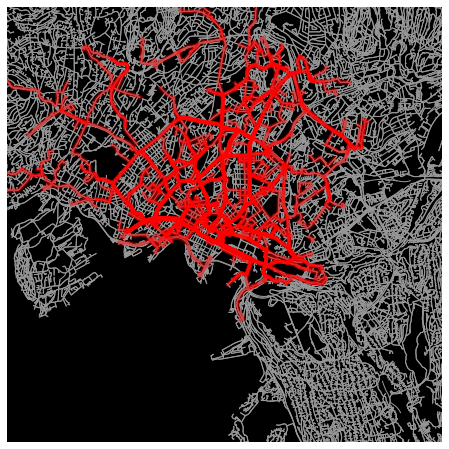

In [16]:
bbox = ox.utils_geo.bbox_from_point((59.914079, 10.750869), dist=5000)
(fig_ox,ax_ox)=ox.plot_graph_routes(road_graph, routes, route_linewidth=1, node_size=0,orig_dest_size=0, bgcolor='k',bbox=bbox);